In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pycalphad import Database, equilibrium, calculate, binplot
from pycalphad import variables as v
from pycalphad.plot.utils import phase_legend

import warnings
import datetime
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm # да, пока что pymc3, я в процессе перехода на pymc тк никаких расчетов с sample делать пока не приходилось
import theano.tensor as tt

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

In [105]:
сс10 = "tdbs/CoCr-01Oik_with_new_functions.tdb"
сс18 = "tdbs/CoCr-18Cac.tdb"

In [106]:
def from_xarray_to_pandas(xarray_data, phase_str):
    cr_tuple = xarray_data.X.sel(component = 'CR').data[0][0]
    phase_tuple = xarray_data.Phase.data[0][0]
    t_tuple = xarray_data.T.data
    
    df_res = pd.DataFrame()
    df_res['T'] = ''
    df_res['phase'] = ''
    df_res['cr_conc'] = ''
    
    df = pd.DataFrame()
    df['T'] = temp_tuple
    df['phase_1'] = ''
    df['phase_2'] = ''
    df['phase_3'] = ''
    df['cr_conc_1'] = ''
    df['cr_conc_2'] = ''
    df['cr_conc_3'] = ''
    
    # print(t_tuple, len(t_tuple))
    for i in range(len(t_tuple)):
        df['phase_1'].iloc[i] = phase_tuple[i][0][0]
        df['phase_2'].iloc[i] = phase_tuple[i][0][1]
        df['phase_3'].iloc[i] = phase_tuple[i][0][2]
        df['cr_conc_1'].iloc[i] = cr_tuple[i][0][0]
        df['cr_conc_2'].iloc[i] = cr_tuple[i][0][1]
        df['cr_conc_3'].iloc[i] = cr_tuple[i][0][2]
    
    df_1 = df[(df['phase_1'] == phase_str)]
    df_1 = df_1[['phase_1', 'cr_conc_1', 'T']]
    df_1.rename(columns = {'phase_1':'phase', 'cr_conc_1':'cr_conc'}, inplace = True)
    
    df_2 = df[(df['phase_2'] == phase_str)]
    df_2 = df_2[['phase_2', 'cr_conc_2', 'T']]
    df_2.rename(columns = {'phase_2':'phase', 'cr_conc_2':'cr_conc'}, inplace = True)
    
    df_res = pd.concat([df_1, df_2])
    
    return df_res

def bin_plot(db, elements, el_cnt): # можно добавить кол-во графиков
    phases = list(db.phases.keys())
    
    fig = plt.figure(figsize=(9,6))
    axes = fig.gca()
    
    binplot(db, elements, phases, {v.X(elements[0]):(0,1,0.02), v.T: (200, 1800, 10), v.P:press, v.N: el_cnt}, plot_kwargs={'ax': axes})
    
    plt.show()

In [107]:
db10 = Database(сс10)
db18 = Database(сс18)

phases10 = list(db10.phases.keys())
phases18 = list(db18.phases.keys())
press = 101325
elements = ['CR', 'CO', 'VA']
el_cnt = 1

#### Суть эксперимента
1. Мы берем две базы данных, в которых по-разному определяется sigma-фаза
2. Далее, мы выбираем две концентрации CR: первая находится в двухфазной области sigma и fcc (0.5), вторая в области sigma и bcc (0.8)
3. Таким образом, мы можем для каждой температуры в этой двухфазной области для каждой фазы определить химический состав
4. Следовательно сравнивать химический состав стабильных фаз для каждой температуры: по эмпирическим данным и по данным, рассчитанным с помощью equlibrium

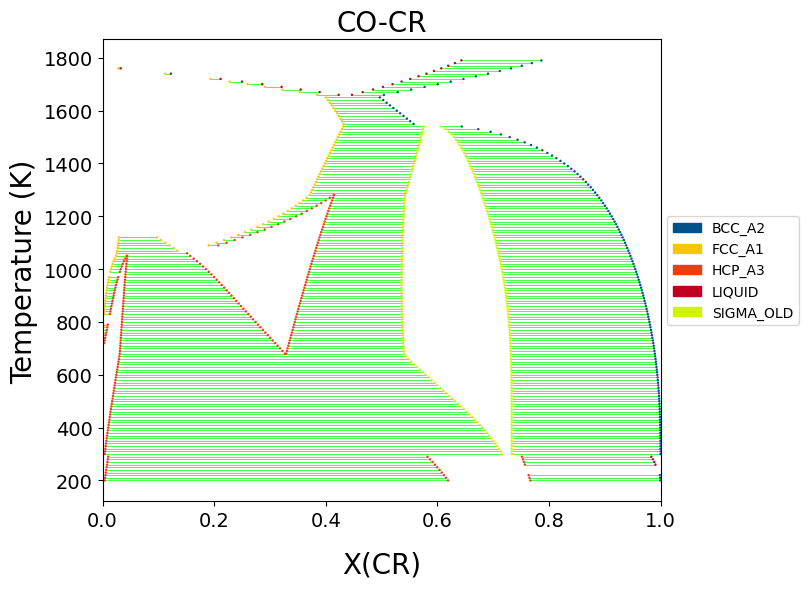

In [108]:
bin_plot(db10, ['CR', 'CO', 'VA'], 1)

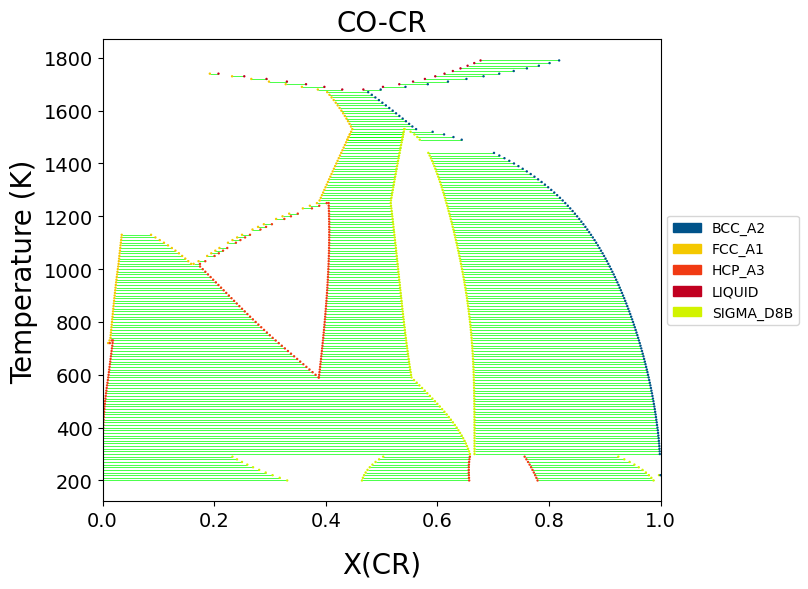

In [72]:
bin_plot(db18, ['CR', 'CO', 'VA'], 1)

Двухфазные области существуют при:
1. $CR = 0.5, T \in \{x;y\}$ соответсвуют фазам $(SIGMA\_OLD, FCC\_A1)$
2. $CR = 0.8, T \in \{m;n\}$ соответсвуют фазам $(SIGMA\_OLD, BCC\_A2)$

#### Получение информации о химическом составе фаз

In [45]:
conditions = {v.X('CR'):0.5, v.P: 101325, v.T: (800, 1750, 1), v.N: el_cnt}
tets_calc = equilibrium(db10, elements, phases10, conditions)

In [157]:
tets_calc

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 950, X_CR: 1, vertex: 3, component: 2, internal_dof: 4)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 800.0 801.0 802.0 ... 1.747e+03 1.748e+03 1.749e+03
  * X_CR       (X_CR) float64 0.5
  * vertex     (vertex) int32 0 1 2
  * component  (component) <U2 'CO' 'CR'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_CR, vertex) float64 0.1917 0.8083 nan ... 1.0 nan nan
    GM         (N, P, T, X_CR) float64 -3.428e+04 -3.433e+04 ... -1.05e+05
    MU         (N, P, T, X_CR, component) float64 -3.354e+04 ... -9.28e+04
    X          (N, P, T, X_CR, vertex, component) float64 0.6555 0.3445 ... nan
    Y          (N, P, T, X_CR, vertex, internal_dof) float64 0.6555 ... nan
    Phase      (N, P, T, X_CR, vertex) <U9 'HCP_A3' 'SIGMA_OLD' '' ... '' ''
Attributes:
    engine:   pycalphad 0.10.1
    created:  2023-03-10T11:32:15.621323

Создадим DataFrame Х - точка, т.е. температура и X(Cr) для фазы

In [360]:
def from_xarray_to_pandas(xarray_data, phase_str):
    cr_tuple = xarray_data.X.sel(component = 'CR').data[0][0]
    phase_tuple = xarray_data.Phase.data[0][0]
    t_tuple = xarray_data.T.data
    
    df_res = pd.DataFrame()
    df_res['T'] = ''
    df_res['phase'] = ''
    df_res['cr_conc'] = ''
    
    df = pd.DataFrame()
    df['T'] = temp_tuple
    df['phase_1'] = ''
    df['phase_2'] = ''
    df['phase_3'] = ''
    df['cr_conc_1'] = ''
    df['cr_conc_2'] = ''
    df['cr_conc_3'] = ''
    
    # print(t_tuple, len(t_tuple))
    for i in range(len(t_tuple)):
        df['phase_1'].iloc[i] = phase_tuple[i][0][0]
        df['phase_2'].iloc[i] = phase_tuple[i][0][1]
        df['phase_3'].iloc[i] = phase_tuple[i][0][2]
        df['cr_conc_1'].iloc[i] = cr_tuple[i][0][0]
        df['cr_conc_2'].iloc[i] = cr_tuple[i][0][1]
        df['cr_conc_3'].iloc[i] = cr_tuple[i][0][2]
    
    df_1 = df[(df['phase_1'] == phase_str)]
    df_1 = df_1[['phase_1', 'cr_conc_1', 'T']]
    df_1.rename(columns = {'phase_1':'phase', 'cr_conc_1':'cr_conc'}, inplace = True)
    
    df_2 = df[(df['phase_2'] == phase_str)]
    df_2 = df_2[['phase_2', 'cr_conc_2', 'T']]
    df_2.rename(columns = {'phase_2':'phase', 'cr_conc_2':'cr_conc'}, inplace = True)
    
    df_res = pd.concat([df_1, df_2])
    
    return df_res

In [361]:
df_test = from_xarray_to_pandas(tets_calc, 'SIGMA_OLD')
df_test

,phase,cr_conc,T
480,SIGMA_OLD,0.541925,1280.0
0,SIGMA_OLD,0.536875,800.0
1,SIGMA_OLD,0.536858,801.0
2,SIGMA_OLD,0.536841,802.0
3,SIGMA_OLD,0.536824,803.0
...,...,...,...
741,SIGMA_OLD,0.575769,1541.0
742,SIGMA_OLD,0.575891,1542.0
743,SIGMA_OLD,0.576014,1543.0
744,SIGMA_OLD,0.576136,1544.0


In [288]:
cr_tuple = tets_calc.X.sel(component = 'CR').data[0][0]
phase_tuple = tets_calc.Phase.data[0][0]
t_tuple = tets_calc.T.data

In [228]:
df10 = pd.DataFrame()
df10['T'] = temp_tuple
df10['phase_1'] = ''
df10['phase_2'] = ''
df10['phase_3'] = ''
df10['cr_conc_1'] = ''
df10['cr_conc_2'] = ''
df10['cr_conc_3'] = ''
for i in range(len(temp_tuple)):
    df10['phase_1'].iloc[i] = phase_tuple[i][0][0]
    df10['phase_2'].iloc[i] = phase_tuple[i][0][1]
    df10['phase_3'].iloc[i] = phase_tuple[i][0][2]
    df10['cr_conc_1'].iloc[i] = cr_tuple[i][0][0]
    df10['cr_conc_2'].iloc[i] = cr_tuple[i][0][1]
    df10['cr_conc_3'].iloc[i] = cr_tuple[i][0][2]

c:\users\emgebrishvili\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,T,phase_1,phase_2,phase_3,cr_conc_1,cr_conc_2,cr_conc_3
0,800.0,HCP_A3,SIGMA_OLD,,0.34449,0.536875,NaN
1,801.0,HCP_A3,SIGMA_OLD,,0.34462,0.536858,NaN
2,802.0,HCP_A3,SIGMA_OLD,,0.34475,0.536841,NaN
3,803.0,HCP_A3,SIGMA_OLD,,0.34488,0.536824,NaN
4,804.0,HCP_A3,SIGMA_OLD,,0.34501,0.536808,NaN
...,...,...,...,...,...,...,...
945,1745.0,LIQUID,,,0.5,NaN,NaN
946,1746.0,LIQUID,,,0.5,NaN,NaN
947,1747.0,LIQUID,,,0.5,NaN,NaN
948,1748.0,LIQUID,,,0.5,NaN,NaN


In [293]:
df_res = df10[(df10['phase_1'] == 'SIGMA_OLD') | (df10['phase_2'] == 'SIGMA_OLD') | (df10['phase_1'] == 'SIGMA_OLD')]

In [294]:
df_res

,T,phase_1,phase_2,phase_3,cr_conc_1,cr_conc_2,cr_conc_3
0,800.0,HCP_A3,SIGMA_OLD,,0.34449,0.536875,NaN
1,801.0,HCP_A3,SIGMA_OLD,,0.34462,0.536858,NaN
2,802.0,HCP_A3,SIGMA_OLD,,0.34475,0.536841,NaN
3,803.0,HCP_A3,SIGMA_OLD,,0.34488,0.536824,NaN
4,804.0,HCP_A3,SIGMA_OLD,,0.34501,0.536808,NaN
...,...,...,...,...,...,...,...
741,1541.0,FCC_A1,SIGMA_OLD,,0.431803,0.575769,NaN
742,1542.0,FCC_A1,SIGMA_OLD,,0.43205,0.575891,NaN
743,1543.0,FCC_A1,SIGMA_OLD,,0.432298,0.576014,NaN
744,1544.0,FCC_A1,SIGMA_OLD,,0.432545,0.576136,NaN


In [244]:
df101 = df10[(df10['phase_1'] == 'FCC_A1') & (df10['phase_2'] == 'SIGMA_OLD')]
df101

,T,phase_1,phase_2,phase_3,cr_conc_1,cr_conc_2,cr_conc_3
481,1281.0,FCC_A1,SIGMA_OLD,,0.371382,0.54205,NaN
482,1282.0,FCC_A1,SIGMA_OLD,,0.371607,0.542191,NaN
483,1283.0,FCC_A1,SIGMA_OLD,,0.371833,0.542332,NaN
484,1284.0,FCC_A1,SIGMA_OLD,,0.372058,0.542472,NaN
485,1285.0,FCC_A1,SIGMA_OLD,,0.372283,0.542613,NaN
...,...,...,...,...,...,...,...
741,1541.0,FCC_A1,SIGMA_OLD,,0.431803,0.575769,NaN
742,1542.0,FCC_A1,SIGMA_OLD,,0.43205,0.575891,NaN
743,1543.0,FCC_A1,SIGMA_OLD,,0.432298,0.576014,NaN
744,1544.0,FCC_A1,SIGMA_OLD,,0.432545,0.576136,NaN


#### Вывод:
Полезные для нас структуры:
1. Phase - строковое имя каждой равновесной фазы при заданных условиях
1. NP - фазовая доля каждой фазы в равновесии
2. MU - хим. потенциал каждого компонента для данных условий
3. X - состав каждого элемента в каждой фазе для расчетных условий (в равновесии)

**Собственно, X хранит те значения, к-е мы и будем сравнивать с экспериментальными.**

ист: https://pycalphad.org/docs/latest/examples/UsingCalculationResults.html

#### Как реализовать замену параметров чз parameters?

In [87]:
conditions = {v.X('CR'):0.5, v.P: 101325, v.T: (800, 1750, 100), v.N: el_cnt}

In [109]:
db10.symbols

{'ZERO': Piecewise((0.0, And(T < 6000.0, 298.15 <= T)), (0, True)),
 'UN_ASS': Piecewise((0.0, And(T < 6000.0, 298.15 <= T)), (0, True)),
 'R': Piecewise((8.31451, And(T < 6000.0, 298.15 <= T)), (0, True)),
 'GHSERCO': Piecewise((310.241 + 133.36601*T - 25.0861*T*log(T) + 72527.0*T**(-1.0) - 0.002654739*T**2.0 - 1.7348e-07*T**3.0, And(T < 1768.0, 298.15 <= T)), (-17197.666 + 253.28374*T - 40.5*T*log(T) + 9.3488e+30*T**(-9.0), And(T < 6000.0, 1768.0 <= T)), (0, True)),
 'GLIQCO': Piecewise((15085.037 + GHSERCO - 8.931932*T - 2.19801e-21*T**7.0, And(T < 1768.0, 298.15 <= T)), (-846.61 + 243.599944*T - 40.5*T*log(T), And(T < 6000.0, 1768.0 <= T)), (0, True)),
 'GFCCCO': Piecewise((427.59 + GHSERCO - 0.615248*T, And(T < 6000.0, 298.15 <= T)), (0, True)),
 'GBCCCO': Piecewise((2938.0 + GHSERCO - 0.7138*T, And(T < 6000.0, 298.15 <= T)), (0, True)),
 'GHSERCR': Piecewise((-8856.94 + 157.48*T - 26.908*T*log(T) + 139250.0*T**(-1.0) + 0.00189435*T**2.0 - 1.47721e-06*T**3.0, And(T < 2180.0, 298.1

In [112]:
parameters = {
 'SIGMA_OLD_COCRCO_0' : (-103863.0)
 ,'SIGMA_OLD_COCRCO_1': 47.47
 ,'SIGMA_OLD_COCRCR_0': (-248108.8)
 ,'SIGMA_OLD_COCRCR_1': 79.12
}

test_y = equilibrium(db10, elements, phases10, conditions, parameters=parameters)
test_y

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 10, X_CR: 1, vertex: 3, component: 2, internal_dof: 4)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 800.0 900.0 1e+03 1.1e+03 ... 1.5e+03 1.6e+03 1.7e+03
  * X_CR       (X_CR) float64 0.5
  * vertex     (vertex) int32 0 1 2
  * component  (component) <U2 'CO' 'CR'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_CR, vertex) float64 0.1917 0.8083 nan ... 1.0 nan nan
    GM         (N, P, T, X_CR) float64 -3.428e+04 -4.027e+04 ... -1.002e+05
    MU         (N, P, T, X_CR, component) float64 -3.354e+04 ... -8.825e+04
    X          (N, P, T, X_CR, vertex, component) float64 0.6555 0.3445 ... nan
    Y          (N, P, T, X_CR, vertex, internal_dof) float64 0.6555 ... nan
    Phase      (N, P, T, X_CR, vertex) <U9 'HCP_A3' 'SIGMA_OLD' '' ... '' ''
Attributes:
    engine:   pycalphad 0.10.1
    created:  2023-03-11T12:51:24.040548

#### Вывод
<u>И тут мне становится непонятно<u>
    
    
В tdb параметры представлены по схеме:
$g^0 + g^{id} +  g^{ex}$\
$g^0 + g^{id}$ - нулевой член,\
$g^{ex}$ - избыточная энергия гиббса смешения

Насколько я понимаю, идея была в том, чтобы распределение параметров, которые обозначены PAR в tdb, задать нормальным в pymc вокруг какого-то среднего, затем переопределить распределение этих параметров в equilibrium, и получить на выходе распределение для расчета апостериорной вероятности.

Но:
1. Мы переопределяем только константы из $g^{ex}$ - почему?\
на вычисление апостериорных распределений выделение только этой части параметров никак не повлияет?\
это будет достаточно точно?
2. Почему мы вообще их переопределяем?\
почему нельзя оставить их в прежнем виде, ведь при определении модели в pymc мы можем задать в качестве среднего константу, к-я соответсвует значению из парамтера.

*Выдержка из документации:\
parameters (dict, optional) – Maps SymEngine Symbol to numbers, for overriding the values of parameters in the Database.*

ист: https://pycalphad.org/docs/latest/api/pycalphad.core.html?highlight=equilibrium#module-pycalphad.core.equilibrium

#### Тестовый прогон расчета правдоподобия

Подгрузим опытные данные

In [376]:
df_sigma_fcc = pd.read_excel('emp_data\sigma_fcc_allibert.xls')
df_sigma_bcc = pd.read_excel('emp_data\sigma_bcc_allibert.xls')
df_sigma_hcp = pd.read_excel('emp_data\sigma_hcp_allibert.xls')

In [378]:
# df_emp = pd.concat([df_sigma_fcc, df_sigma_bcc, df_sigma_hcp], sort = True)
# df_emp['T'] = df_emp['T'].round(2)
# df_emp['cr_conc'] = df_emp['cr_conc'].round(4)
# df_emp.head()

Проведем эксперимент для области **fcc&sigma**

In [377]:
df_sigma_fcc['T'] = df_sigma_fcc['T'].round(2)
df_sigma_fcc['cr_conc'] = df_sigma_fcc['cr_conc'].round(6)
df_sigma_fcc_sigma_old = df_sigma_fcc[(df_sigma_fcc['phase'] == 'sigma_old')].reset_index()
df_sigma_fcc_sigma_old

,index,cr_conc,T,phase
0,6,0.532019,1321.35,sigma_old
1,7,0.542469,1226.97,sigma_old
2,8,0.547749,1471.91,sigma_old
3,9,0.554050,1370.79,sigma_old
4,10,0.556156,1269.66,sigma_old
5,11,0.559283,1422.47,sigma_old


In [367]:
df_sigma_fcc_sigma_old.sort_values('T')
T = df_sigma_fcc_sigma_old['T'].to_numpy()
y_emp =  df_sigma_fcc_sigma_old['cr_conc'].to_numpy()

сс10_model = pm.Model()
with сс10_model as model:
    
    # распределение нулевого члена
    # не знаю какую брать дисперсию, вязла ту, что быстрее отрабатывает
    SIGMA_OLD_COCRCO_0 = pm.Normal("SIGMA_OLD_COCRCO_0", mu=-103863.0, sigma=1)
    SIGMA_OLD_COCRCO_1 = pm.Normal("SIGMA_OLD_COCRCO_1", mu=47.47, sigma=1)
    SIGMA_OLD_COCRCR_0 = pm.Normal("SIGMA_OLD_COCRCR_0", mu=-248108.8, sigma=1)
    SIGMA_OLD_COCRCR_1 = pm.Normal("SIGMA_OLD_COCRCR_1", mu=79.12, sigma=1) 
    
    # задали распределение результирующих значений модели на основании новых распределений параметров
    conditions = {v.X('CR'):0.5, v.P: 101325, v.T: T, v.N: el_cnt}
    N_parameters = {
     'SIGMA_OLD_COCRCO_0' : -103863.0
     ,'SIGMA_OLD_COCRCO_1': 47.47
     ,'SIGMA_OLD_COCRCR_0': -248108.8
     ,'SIGMA_OLD_COCRCR_1': 79.12
    }
    
    y_calc = equilibrium(db10, elements, phases10, conditions, parameters = N_parameters)
    y_eval = from_xarray_to_pandas(y_calc, 'SIGMA_OLD').sort_values('T')
    y_eval = y_eval['cr_conc']
    
    # посчитали правдоподобие модели
    y_obs = pm.Normal("y_obs", mu=y_eval, observed=y_emp)

    # посчитали апостериорное распределение
    # trace = pm.sample(1000, tune=1000)

In [368]:
with сс10_model as model:
    trace = pm.sample(1000, tune=1000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\users\emgebrishvili\appdata\local\programs\python\python37\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [SIGMA_OLD_COCRCR_1, SIGMA_OLD_COCRCR_0, SIGMA_OLD_COCRCO_1, SIGMA_OLD_COCRCO_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


Цепи выглядят нормально

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'SIGMA_OLD_COCRCO_0'}>,
        <AxesSubplot:title={'center':'SIGMA_OLD_COCRCO_0'}>],
       [<AxesSubplot:title={'center':'SIGMA_OLD_COCRCO_1'}>,
        <AxesSubplot:title={'center':'SIGMA_OLD_COCRCO_1'}>],
       [<AxesSubplot:title={'center':'SIGMA_OLD_COCRCR_0'}>,
        <AxesSubplot:title={'center':'SIGMA_OLD_COCRCR_0'}>],
       [<AxesSubplot:title={'center':'SIGMA_OLD_COCRCR_1'}>,
        <AxesSubplot:title={'center':'SIGMA_OLD_COCRCR_1'}>]],
      dtype=object)

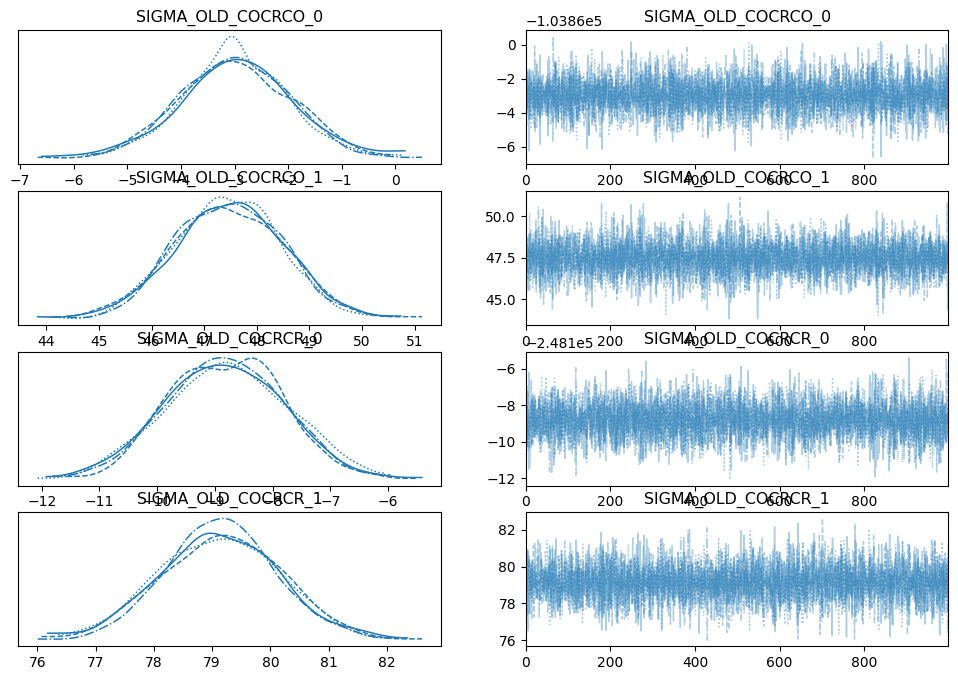

In [369]:
az.plot_trace(trace)

In [372]:
with сс10_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
SIGMA_OLD_COCRCO_0,-103862.97,1.01,-103864.92,-103861.09,0.01,0.01,7060.84,3172.21,1.0
SIGMA_OLD_COCRCO_1,47.47,1.02,45.51,49.26,0.01,0.01,6538.80,3231.34,1.0
SIGMA_OLD_COCRCR_0,-248108.82,1.01,-248110.71,-248107.00,0.01,0.01,6015.00,2610.50,1.0
SIGMA_OLD_COCRCR_1,79.14,1.01,77.16,80.90,0.01,0.01,7120.54,3245.16,1.0


#### Итог

Построила правдоподобие и апостериорное распределение для одной фазы, но по ходу реализации возникали вопросы, поэтому хочу чтобы вы подтвердили правильно ли я это сделала или нет.

Насколько понимаю, дальше чтобы сравнить модели, нужно для этой же фазы построить вторую модель, посчитать ее апостериорное распределение и получить BF.

На счет опытных данных: их очень мало, для данного эксперимента использовалось 6 точек, так и должно быть или я чего-то не понимаю? может быть их можно как то догенерировать?

В общем то, основной вопрос: в правильном ли направлении я двигаюсь или что-то лучше поправить уже на этом этапе.

И еще вопрос по поводу тезисов: 
нам их до 17 числа надо отправить, при этом, их могут еще и прислать обратно на доработку...\
на данном этапе у меня есть все, чтобы начать их писать? какого объема текст нужно написать?